# Data Wrangling project: @dog_rates tweet data

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
from timeit import default_timer as timer
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Gathering

I first must import all necessary data.

#### 1. Main tweet data .csv file
This file is provided directly.

In [2]:
maintweets_df = pd.read_csv('twitter-archive-enhanced.csv')

#### 2. Breed predictions .tsv file

To be downloaded programatically from supplied url using `requests` library.

Predictions of dog breed based on tweeted images.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
'''I comment out the following lines to avoid downloading the file again'''
#response = requests.get(url)
#with open('image-predictions.tsv', 'wb') as file:
#    file.write(response.content)

'I comment out the following lines to avoid downloading the file again'

In [4]:
breedpredict_df = pd.read_csv('image-predictions.tsv', sep='\t')

#### 3. Additional data from Twitter in JSON format

To be queried from Twitter API using `tweepy` library.

I first demonstrate the code for extracting the data in JSON format and building a dataframe in the two cells below (I will hide my keys and tokens before submitting the file). Only four tweet IDs will be queried, so the resulting sample dataframe will have only four rows.


In the cells following this demonstration I will import the data resulting from querying all 2356 tweet IDs from the main table. The `.txt` file containing this full JSON data is attached in the submission, and was produced with the same code shown here.

In [5]:
consumer_key = 'I use my own keys and tokens'
consumer_secret = 'I use my own keys and tokens'
access_token = 'I use my own keys and tokens'
access_secret = 'I use my own keys and tokens'

def extract_extended_data(consumer_key, consumer_secret, access_token, access_secret):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    tweet_ids = maintweets_df.tweet_id.values

    # Query Twitter's API for JSON data for each tweet ID in the archive
    count = 0
    # Create fails dictionary in case I need to retrieve failed IDs (not required)
    fails_dict = {}
    # Create a list to contain all the JSON objects so that they can be loaded later
    tweet_json_list = []
    start = timer()
    with open('tweet_json_sample.txt', 'w') as outfile:
        '''I demonstrate with only two tweets to have a quick result'''
        for tweet_id in tweet_ids[:2]:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                #Append each JSON to the list
                tweet_json_list.append(tweet._json)
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
        # Finally, dump the list as JSON to the file, indented for readability
        json.dump(tweet_json_list, outfile, indent=4)
    # Printing the time elapsed is not required either but it can be useful
    end = timer()
    print(str(end - start)[:4] + ' seconds.')

'''the function is commented out to prevent it from failing to run with no keys:'''
#extract_extended_data(consumer_key, consumer_secret, access_token, access_secret)

'''Again this is a sample'''
with open('tweet_json_sample.txt') as json_file:
    extended_sample = json.load(json_file)
extended_sample

[{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
  'id': 892420643555336193,
  'id_str': '892420643555336193',
  'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
  'truncated': False,
  'display_text_range': [0, 85],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 892420639486877696,
     'id_str': '892420639486877696',
     'indices': [86, 109],
     'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'url': 'https://t.co/MgUWQ76dJU',
     'display_url': 'pic.twitter.com/MgUWQ76dJU',
     'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
     'type': 'photo',
     'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
      'small': {'w': 540, 'h': 528, 'resize': 'fit'}

In [6]:
'''Sample dataframe'''
# to find the columns for my dataframe, I need a list of all the keys in each JSON object
extendedsample_df = pd.DataFrame(extended_sample, columns=list(extended_sample[0].keys()))
extendedsample_df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",None,...,None,None,False,8250,37826,False,False,False,False,en
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",None,...,None,None,False,6094,32503,False,False,False,False,en


In [7]:
# import the full JSON data
with open('tweet_json_final.txt') as json_file:
    extended_data = json.load(json_file)
    
extdf_cols = list(extended_data[0].keys())

In [8]:
# make a dataframe
extendedinfo_df = pd.DataFrame(extended_data, columns=extdf_cols)
#extendedinfo_df.head(3)

## Assessing

Main tweets table

In [9]:
maintweets_df.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
626,795076730285391872,NaN,NaN,2016-11-06 01:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. She loves going down slides bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/795076730...,11,10,Bailey,None,None,None,None
2263,667544320556335104,NaN,NaN,2015-11-20 03:25:43 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/667544320...,10,10,Kial,None,None,None,None
216,850753642995093505,NaN,NaN,2017-04-08 16:54:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Kyle. He made a joke about your shoes,...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/850753642...,11,10,Kyle,None,None,None,None
1199,716791146589110272,NaN,NaN,2016-04-04 00:55:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jennifur. She's supposed to be navigating...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716791146...,11,10,Jennifur,None,None,None,None


In [10]:
maintweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
# Are the tweet texts complete? What is the maximum length?
maintweets_df.text.str.len().max()

167

In [12]:
# Make sure the rows with non-null values in *retweeted_status_user_id* are in fact retweets
maintweets_df[maintweets_df.retweeted_status_id.notnull()].sample(6)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @katieornah: @dog_rates learning a lot at c...,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,https://twitter.com/katieornah/status/77100213...,12,10,None,None,None,pupper,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
230,847978865427394560,NaN,NaN,2017-04-01 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Charlie. He fell asleep...,8.323699e+17,4.196984e+09,2017-02-16 23:23:38 +0000,https://twitter.com/dog_rates/status/832369877...,11,10,Charlie,None,None,None,None
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Yep... just as I suspected. Yo...",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,https://twitter.com/dog_rates/status/777684233...,12,10,None,None,None,None,None
728,782021823840026624,NaN,NaN,2016-10-01 00:58:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Harper. She scraped her...,7.076109e+17,4.196984e+09,2016-03-09 16:56:11 +0000,https://twitter.com/dog_rates/status/707610948...,12,10,Harper,None,None,None,None
182,856602993587888130,NaN,NaN,2017-04-24 20:17:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Luna. It's her first ti...,8.447048e+17,4.196984e+09,2017-03-23 00:18:10 +0000,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None


In [13]:
# how many not 'None' in dog stages?
maintweets_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [14]:
# how many not 'None' in dog stages?
len(maintweets_df.query('doggo != "None"')) + len(
    maintweets_df.query('floofer != "None"')) + len(
    maintweets_df.query('pupper != "None"')) + len(maintweets_df.query('puppo != "None"'))

394

In [15]:
# how many 'None' in name?
len(maintweets_df.query('name == "None"'))

745

In [16]:
maintweets_df.name.value_counts()

None            745
a                55
Charlie          12
Oliver           11
Cooper           11
Lucy             11
Penny            10
Tucker           10
Lola             10
Bo                9
Winston           9
Sadie             8
the               8
an                7
Toby              7
Daisy             7
Bailey            7
Buddy             7
Milo              6
Jack              6
Leo               6
Bella             6
Scout             6
Rusty             6
Dave              6
Oscar             6
Jax               6
Koda              6
Stanley           6
Chester           5
               ... 
Ron               1
Crimson           1
Jeffrie           1
Shadoe            1
Ember             1
Daniel            1
unacceptable      1
Keet              1
Chase             1
Smiley            1
Ginger            1
Grey              1
Jeffri            1
Venti             1
Spark             1
Pepper            1
Hazel             1
Burt              1
Banjo             1


In [17]:
# how many possibly wrong names?
len(maintweets_df[maintweets_df.name.str.islower()])

109

In [18]:
# what are these lowercase names?
maintweets_df[maintweets_df.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
quite            4
just             4
one              4
actually         2
not              2
getting          2
mad              2
incredibly       1
all              1
space            1
life             1
light            1
old              1
such             1
unacceptable     1
this             1
my               1
his              1
by               1
infuriating      1
officially       1
Name: name, dtype: int64

Breed predictions table

In [19]:
breedpredict_df.sample(4)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1988,872820683541237760,https://pbs.twimg.com/media/DBzhx0PWAAEhl0E.jpg,3,pug,0.999120,True,French_bulldog,0.000552,True,bull_mastiff,0.000073,True
122,668221241640230912,https://pbs.twimg.com/media/CUX_rAyWsAYZOQ5.jpg,1,chow,0.395101,True,golden_retriever,0.372115,True,Labrador_retriever,0.148785,True
1453,776819012571455488,https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
534,676936541936185344,https://pbs.twimg.com/media/CWT2MUgWIAECWig.jpg,1,Chesapeake_Bay_retriever,0.545286,True,Norwegian_elkhound,0.081482,True,space_heater,0.047391,False


In [20]:
breedpredict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
# look at mean confidence value for each of the three predictions
breedpredict_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [22]:
# number of different identified objects in the first prediction
len(breedpredict_df.p1.value_counts())

378

In [23]:
# percentage of images identified as dogs in the first prediction
len(breedpredict_df[breedpredict_df.p1_dog])/len(breedpredict_df.p1_dog)

0.7383132530120482

In [24]:
# number of different dog breeds identified in the first prediction
len(breedpredict_df.query('p1_dog').p1.value_counts())

111

In [25]:
breedpredict_df.query('p1_dog').p1.value_counts()

golden_retriever                  150
Labrador_retriever                100
Pembroke                           89
Chihuahua                          83
pug                                57
chow                               44
Samoyed                            43
toy_poodle                         39
Pomeranian                         38
malamute                           30
cocker_spaniel                     30
French_bulldog                     26
miniature_pinscher                 23
Chesapeake_Bay_retriever           23
Siberian_husky                     20
Staffordshire_bullterrier          20
German_shepherd                    20
Cardigan                           19
beagle                             18
Eskimo_dog                         18
Shetland_sheepdog                  18
Maltese_dog                        18
Shih-Tzu                           17
Lakeland_terrier                   17
Rottweiler                         17
Italian_greyhound                  16
kuvasz      

Extended tweet data table

In [26]:
extendedinfo_df.sample(4)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang
959,Mon Jul 04 19:00:33 +0000 2016,750041628174217216,750041628174217216,This is Beau. He's trying to keep his daddy fr...,False,"[0, 111]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 749828107587248128, 'id_str'...","<a href=""https://about.twitter.com/products/tw...",NaN,...,None,None,False,662,3325,False,False,False,False,en
926,Tue Jul 12 17:27:23 +0000 2016,752917284578922496,752917284578922496,This is Grizzie. She's a semi-submerged Bahrai...,False,"[0, 116]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 752917276685438976, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,1687,7240,False,False,False,False,en
261,Mon Mar 13 15:47:01 +0000 2017,841314665196081154,841314665196081154,This is Max. There's no way in h*ck you're tak...,False,"[0, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 841311812641533952, 'id_str'...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,...,None,None,False,4978,16437,False,False,False,False,en
75,Fri Jun 23 01:10:23 +0000 2017,878057613040115712,878057613040115712,This is Emmy. She was adopted today. Massive r...,False,"[0, 115]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 878057599261745152, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,6640,41106,False,False,False,False,en


In [27]:
extendedinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 27 columns):
created_at                       2339 non-null object
id                               2339 non-null int64
id_str                           2339 non-null object
full_text                        2339 non-null object
truncated                        2339 non-null bool
display_text_range               2339 non-null object
entities                         2339 non-null object
extended_entities                2065 non-null object
source                           2339 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null object
in_reply_to_screen_name          77 non-null object
user                             2339 non-null object
geo                              0 non-null object
coordinates                      0 non-null

In [28]:
# What is the maximum tweet text length in this table?
extendedinfo_df.full_text.str.len().max()

167

In [29]:
extendedinfo_df.describe()

,id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count
count,2.339000e+03,7.700000e+01,7.700000e+01,2339.000000,2339.000000
mean,7.421620e+17,7.440692e+17,2.040329e+16,2907.487815,7908.548953
std,6.828729e+16,7.524295e+16,1.260797e+17,4901.594336,12257.423888
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,0.000000
25%,6.783378e+17,6.757073e+17,3.589728e+08,584.000000,1367.500000
50%,7.186133e+17,7.032559e+17,4.196984e+09,1356.000000,3444.000000
75%,7.986907e+17,8.233264e+17,4.196984e+09,3389.000000,9692.500000
max,8.924206e+17,8.862664e+17,8.405479e+17,83081.000000,163378.000000


### Quality

`maintweets` table

1. Rows corresponding to retweets are present
2. Tweet ID datatype should be string
3. Timestamp should be datetime format
4. Some of the dogs' names are common words registered wrongly
5. 'None' strings and nulls as values mixed in text fields could be a problem for indexing.

`breedpredict` table

6. Dog breed names have inconsistent formats
7. Rows with images identified as non-dog are present
8. Dog breed datatype should be category
9. Non-descriptive variable names

### Tidiness

1. Several columns for dog stage, should be one
2. Several columns for predicted dog breed, should be one
3. Three tables should be unified into one: the variables *retweet_count* and *favorite_count* from `extendedinfo`, and *p1* and *jpeg_url* from `breedpredict`, should be merged into `maintweets` using *tweet_id* as key; several other columns from `maintweets` that will not be used in the analysis should be removed.

## Cleaning

First I make a copy of the three tables:

In [30]:
main_clean = maintweets_df.copy()

In [31]:
breed_clean = breedpredict_df.copy()

In [32]:
extend_clean = extendedinfo_df.copy()

### Unwanted observations

#### `main` table:

Since the analysis will be based on the tweet data from the `main` table, before doing more work I remove all observations that correspond to retweets first from this table to comply with the project guidelines.

##### Define

Remove all rows that correspond to retweets.

##### Code

In [33]:
# use indexing to reduce the dataframe to observations that are not retweets
main_clean = main_clean[main_clean.retweeted_status_id.isnull()]

##### Test

In [34]:
main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### `breed` table:

I want to use dog breed information in my analysis, so I will keep only the observations that have a prediction of a dog breed, and also have at least 33% confidence in the first prediction.

This decision also solves the tidiness issue of the breed prediction variable's information being spread over several columns, since I will only use the strongest prediction (contained always in the column *p1*).

##### Define

Reduce the table to only the rows where *p1_dog* is `True` and *p1_conf* is at least .33.

##### Code

In [35]:
breed_clean = breed_clean.query('p1_conf >= .33 & p1_dog')

##### Test

In [36]:
# percentage of images identified as dogs in p1 after cleaning
len(breed_clean[breed_clean.p1_dog])/len(breed_clean)

1.0

In [37]:
# number of rows remaining and values of p1_conf
breed_clean.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,1.264000e+03,1264.000000,1264.000000,1264.000000,1.264000e+03
mean,7.456465e+17,1.244462,0.694517,0.136934,5.194508e-02
std,6.913040e+16,0.614847,0.208755,0.108877,4.946894e-02
min,6.660209e+17,1.000000,0.330171,0.000023,2.160900e-07
25%,6.801384e+17,1.000000,0.509945,0.044376,9.931482e-03
50%,7.276651e+17,1.000000,0.707540,0.116180,3.833030e-02
75%,8.026676e+17,1.000000,0.887646,0.203774,7.969630e-02
max,8.918152e+17,4.000000,0.999956,0.467678,2.734190e-01


This still sets the median breed prediction confidence at 69%, with only 25% of predictions having less than 50% condifence.

### Tidiness

#### `main` table: Dog stage information is spread over several coumns.

##### Define

Create one single column containing dog stage information.

##### Code

In [38]:
# first replace all 'None' strings in the stage columns with empty strings to be able to sum
main_clean.doggo.replace({'None':''}, inplace=True)
main_clean.floofer.replace({'None':''}, inplace=True)
main_clean.pupper.replace({'None':''}, inplace=True)
main_clean.puppo.replace({'None':''}, inplace=True)

In [39]:
# create a new column with the sum of the strings in the original four columns
main_clean['dog_stage'] = main_clean.doggo + main_clean.floofer + main_clean.pupper + main_clean.puppo

In [40]:
# finally replace all empty strings with proper 'None' strings again to prevent indexing issues
main_clean.doggo.replace({'':'None'}, inplace=True)
main_clean.floofer.replace({'':'None'}, inplace=True)
main_clean.pupper.replace({'':'None'}, inplace=True)
main_clean.puppo.replace({'':'None'}, inplace=True)
main_clean.dog_stage.replace({'':'None'}, inplace=True)

##### Test

In [41]:
main_clean.dog_stage.value_counts()

None            1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

Some **iteration** is necessary to solve this issue; I will visually **assess** tweet texts in the cases of mixed dog stages before **cleaning** again:

In [42]:
# (remove displayed text length limit for visual asssessment)
pd.reset_option('^display')
pd.set_option('display.max_colwidth', -1)
main_clean[main_clean.dog_stage.str.len() > 7].text

191     Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel      
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
460     This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531     Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho                    
565     Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze                                                                                               
575     This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https:

In [43]:
# (reset displayed text length limit)
pd.reset_option('^display')

It looks like the occurrences of doggo + pupper are all actual cases of two dogs in the picture. In the other two cases, it seems best to keep only the first identified dog stage.

Since the number of occurrences is small, this type of visual assessment and a quick solution using `.replace()` are possible; if there were many occurrences a different approach to the previous coding step would be necessary.

##### Define

Replace the occurrences of mixed dog stage.

#### Code

In [44]:
main_clean.dog_stage.replace({'doggopupper':'a doggo and a pupper',
                                 'doggopuppo':'doggo',
                                 'doggofloofer':'doggo'}, inplace=True)

#### Test

In [45]:
main_clean.dog_stage.value_counts()

None                    1831
pupper                   224
doggo                     77
puppo                     24
a doggo and a pupper      10
floofer                    9
Name: dog_stage, dtype: int64

#### Information from `breed` and `extended` tables should be merged with `main` into a single `master` table.

##### Define

Merge `breed` and `extended` tables into `main`.

##### Code

In [46]:
# check for duplicated values in the column names of the three tables
all_columns = pd.Series(list(main_clean)+list(breed_clean)+list(extend_clean))
all_columns[all_columns.duplicated()]

18                 tweet_id
38                   source
39    in_reply_to_status_id
41      in_reply_to_user_id
dtype: object

In [47]:
master_df = pd.merge(main_clean, breed_clean, on='tweet_id', how='left')

In [48]:
# rename id column in extended table to match the other two
extend_clean.rename(columns={'id':'tweet_id'}, inplace=True)

In [49]:
master_df = pd.merge(master_df, extend_clean, on='tweet_id', how='inner')

##### Test

In [50]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 55 columns):
tweet_id                         2172 non-null int64
in_reply_to_status_id_x          78 non-null float64
in_reply_to_user_id_x            78 non-null float64
timestamp                        2172 non-null object
source_x                         2172 non-null object
text                             2172 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2114 non-null object
rating_numerator                 2172 non-null int64
rating_denominator               2172 non-null int64
name                             2172 non-null object
doggo                            2172 non-null object
floofer                          2172 non-null object
pupper                           2172 non-null object
puppo                            2172 non

#### Remove unnecessary columns before further cleaning

##### Define

Drop columns that will not be used in the analysis.

##### Code

In [51]:
master_clean = master_df.copy()

In [52]:
columns_to_keep = ['tweet_id', 'timestamp', 'text', 'rating_numerator',
                   'rating_denominator', 'name', 'dog_stage', 'jpg_url',
                  'p1', 'retweet_count', 'favorite_count']

In [53]:
master_clean.drop(columns=[x for x in master_clean.columns if x not in columns_to_keep], inplace=True)

##### Test

In [54]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 11 columns):
tweet_id              2172 non-null int64
timestamp             2172 non-null object
text                  2172 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
name                  2172 non-null object
dog_stage             2172 non-null object
jpg_url               1213 non-null object
p1                    1213 non-null object
retweet_count         2172 non-null int64
favorite_count        2172 non-null int64
dtypes: int64(5), object(6)
memory usage: 203.6+ KB


### Quality

##### Issues already addressed (unwanted observations):

 - Tweet data corresponding to retweets removed
 - Image prediction data for to weak or non-dog predictions removed

##### Remaining issues:

 Contents of cells
   - Some of the dogs' names are common words registered wrongly
   - Dog breed names have inconsistent formats (lowercase and uppercase mixed)
   - `NaN` in text columns may be a problem for indexing
 
 
 Wrong data types
   - Tweet ID datatype should be string
   - Timestamp should be datetime or date format
   - Dog stage and dog breed datatypes should be category
   
   
 Other
  - Non-descriptive variable names



#### Dog names registered incorrectly

##### Define

For cases of non-names in the *name* column, replace with 'None' strings.

##### Code

In [55]:
master_clean.name = master_clean.name.mask(master_clean.name.str.islower(), 'None')

##### Test

In [56]:
master_clean.name.value_counts().head(15)

None       784
Lucy        11
Cooper      10
Charlie     10
Oliver      10
Tucker       9
Penny        9
Lola         8
Winston      8
Sadie        8
Daisy        7
Toby         7
Jax          6
Oscar        6
Koda         6
Name: name, dtype: int64

#### Inconsistent breed name format and `NaN` values

##### Define

Capitalize all breed names and replace `NaN` with 'None' strings, this operation also for the *dog_stage* and *jpg_url* columns.

##### Code

In [57]:
master_clean.p1 = master_clean.p1.str.title()
master_clean.p1.replace({np.nan:'None'}, inplace=True)
master_clean.jpg_url.replace({np.nan:'None'}, inplace=True)

##### Test

In [58]:
master_clean.p1.value_counts().head(15)

None                        959
Golden_Retriever            125
Pembroke                     83
Labrador_Retriever           83
Chihuahua                    63
Pug                          51
Pomeranian                   36
Samoyed                      35
Toy_Poodle                   34
Chow                         32
Malamute                     26
French_Bulldog               23
Cocker_Spaniel               22
German_Shepherd              19
Chesapeake_Bay_Retriever     18
Name: p1, dtype: int64

In [59]:
master_clean.dog_stage.value_counts()

None                    1828
pupper                   224
doggo                     77
puppo                     24
a doggo and a pupper      10
floofer                    9
Name: dog_stage, dtype: int64

#### Wrong datatypes

##### Define

Change datatypes of variables *tweet_id*, *timestamp*, *dog_stage* and *p1*.

##### Code

In [60]:
master_clean.timestamp = pd.to_datetime(master_clean.timestamp)
master_clean.timestamp = master_clean.timestamp.dt.date
master_clean.tweet_id = master_clean.tweet_id.astype(str)
master_clean.dog_stage = master_clean.dog_stage.astype('category')
master_clean.p1 = master_clean.p1.astype('category')

##### Test

In [61]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 11 columns):
tweet_id              2172 non-null object
timestamp             2172 non-null object
text                  2172 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
name                  2172 non-null object
dog_stage             2172 non-null category
jpg_url               2172 non-null object
p1                    2172 non-null category
retweet_count         2172 non-null int64
favorite_count        2172 non-null int64
dtypes: category(2), int64(4), object(5)
memory usage: 180.0+ KB


#### Non-descriptive column names

##### Define

Change column names to descriptive ones

##### Code

In [62]:
master_clean.rename(columns={'timestamp':'date',
                             'text':'tweet_text',
                             'name':'dog_name',
                             'jpg_url':'image_url',
                             'p1':'dog_breed'}, inplace=True)

##### Test

In [63]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 11 columns):
tweet_id              2172 non-null object
date                  2172 non-null object
tweet_text            2172 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
dog_name              2172 non-null object
dog_stage             2172 non-null category
image_url             2172 non-null object
dog_breed             2172 non-null category
retweet_count         2172 non-null int64
favorite_count        2172 non-null int64
dtypes: category(2), int64(4), object(5)
memory usage: 180.0+ KB


## Storing

I store the clean dataset ready for analysis in a separate file.

In [64]:
master_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis

In [65]:
df = pd.read_csv('twitter_archive_master.csv', dtype={'tweet_id': object})

In [66]:
pd.set_option('display.max_colwidth', -1)
df.sample(2)

,tweet_id,date,tweet_text,rating_numerator,rating_denominator,dog_name,dog_stage,image_url,dog_breed,retweet_count,favorite_count
224,842765311967449089,2017-03-17,Meet Indie. She's not a fan of baths but she's definitely a fan of hide &amp; seek. 12/10 click the link to help Indie\r\n\r\nhttps://t.co/fvGkIuAlFK https://t.co/kiCFtmJd7l,12,10,Indie,None,None,None,1348,6995
635,774314403806253056,2016-09-09,I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS https://t.co/7oQ1wpfxIH,14,10,None,None,https://pbs.twimg.com/media/Cr7q1VxWIAA5Nm7.jpg,Eskimo_Dog,6020,23033


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 11 columns):
tweet_id              2172 non-null object
date                  2172 non-null object
tweet_text            2172 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
dog_name              2172 non-null object
dog_stage             2172 non-null object
image_url             2172 non-null object
dog_breed             2172 non-null object
retweet_count         2172 non-null int64
favorite_count        2172 non-null int64
dtypes: int64(4), object(7)
memory usage: 186.7+ KB


In [68]:
print('Earliest tweet: {}\nLatest tweet: {}'.format(df.date.min(), df.date.max()))

Earliest tweet: 2015-11-15
Latest tweet: 2017-08-01


The dataset contains information about one thousand tweets ranging almost two years in time. I would like to see if there is any trend in the amount of favorites and retweets.

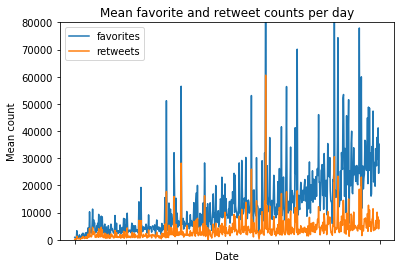

In [69]:
df.groupby('date')['favorite_count'].mean().plot(label='favorites')
df.groupby('date')['retweet_count'].mean().plot(label='retweets')
plt.title('Mean favorite and retweet counts per day')
plt.ylim(0, 80000)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Mean count')
plt.savefig('meanfavcount_day.png', dpi=300, bbox_inches='tight');

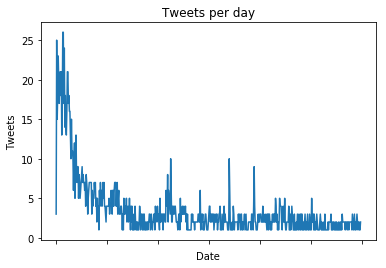

In [70]:
df.groupby('date')['tweet_id'].count().plot()
plt.title('Tweets per day')
plt.xlabel('Date')
plt.ylabel('Tweets');

There seems to be a steady growth in the popularity of the account during 2016 and 2017, while the amont of tweets per day stayed constant or decreased.

I want to see a summary of the numerical variables, particularly the rating numerator and denominator which are a key element of the popularity of this Twitter account.

In [71]:
df.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2172.000000,2172.000000,2172.000000,2172.000000
mean,13.217311,10.493554,2621.489411,8516.618785
std,47.758603,7.023908,4652.964032,12514.816046
min,0.000000,0.000000,0.000000,51.000000
25%,10.000000,10.000000,565.500000,1805.750000
50%,11.000000,10.000000,1252.000000,3843.500000
75%,12.000000,10.000000,2984.000000,10592.750000
max,1776.000000,170.000000,83081.000000,163378.000000


The summary shows that, while the most common values for both numerator and denominator seems to be 10, the mean numerator is slightly higher than the denominator which is one of the recognisable features of tweets by @dog_rates.

It is also apparent that retweets are less common than favorites.

In [72]:
df.dog_stage.value_counts()

None                    1828
pupper                  224 
doggo                   77  
puppo                   24  
a doggo and a pupper    10  
floofer                 9   
Name: dog_stage, dtype: int64

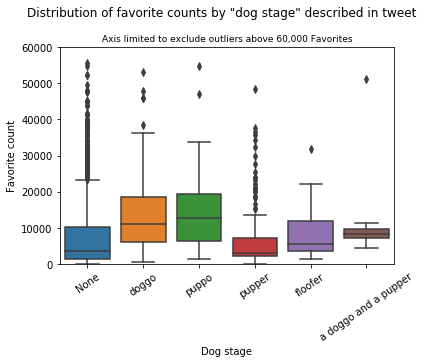

In [73]:
sns.boxplot(x='dog_stage', y='favorite_count', data=df)
plt.ylim(0, 60000)
title_string = 'Distribution of favorite counts by "dog stage" described in tweet'
subtitle_string = 'Axis limited to exclude outliers above 60,000 Favorites'
plt.suptitle(title_string, y=1.02, fontsize=12)
plt.title(subtitle_string, fontsize=9)
plt.xlabel('Dog stage')
plt.ylabel('Favorite count')
plt.xticks(rotation=35)
plt.savefig('favcount_stage.png', dpi=300, bbox_inches='tight');

In [74]:
top_breeds = [x for x in df.dog_breed.value_counts().keys() if df.dog_breed.value_counts()[x] > 30]
df_top_breeds = df[df.dog_breed!='None']
df_top_breeds = df_top_breeds[df_top_breeds.dog_breed.isin(top_breeds)]
df_top_breeds.dog_breed.value_counts()

Golden_Retriever      125
Pembroke              83 
Labrador_Retriever    83 
Chihuahua             63 
Pug                   51 
Pomeranian            36 
Samoyed               35 
Toy_Poodle            34 
Chow                  32 
Name: dog_breed, dtype: int64

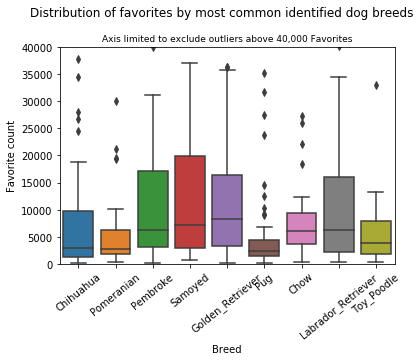

In [75]:
df_top_breeds = df[df.dog_breed!='None']
df_top_breeds = df_top_breeds[df_top_breeds.dog_breed.isin(top_breeds)]
sns.boxplot(x='dog_breed', y='favorite_count', data=df_top_breeds)
plt.ylim(0, 40000)
plt.xticks(rotation=39)
plt.xlabel('Breed')
plt.ylabel('Favorite count')
title_string = 'Distribution of favorites by most common identified dog breeds'
subtitle_string = 'Axis limited to exclude outliers above 40,000 Favorites'
plt.suptitle(title_string, y=1.02, fontsize=12)
plt.title(subtitle_string, fontsize=9)
plt.savefig('favcount_breed.png', dpi=300, bbox_inches='tight');

#### Insights

1. While the amount of tweets per day stayed constant or slightly decreased, the mean number of retweets and especially favorites per day steadily increased throughout the period with available data. Favorites more common than retweets, with the median and maximum values reaching around 1,200 and 83,000 in the case of retweets, and 3,800 and 163,000 in the case of favorites.


2. The ratings' denominator is almost always 10, and the numerator is most often between 10 and 12, but both go higher than these values sometimes. This characteristic rating style is always present in the humorous tweets of this account and is one of the reasons for its popularity.


3. Among the tweets explicitly mentioning the "dog stage", those sharing pictures of a "pupper"(baby dog) are most common but the medians of the favorite counts for "doggos"(adult dogs) and "puppos"(teenage dogs) are more than twice as high as those of "puppers". The median favorite count for tweets that don't mention the dog's developmental stage is also significantly lower than those of "doggos" and "puppos", but similar to the one for "puppers". This may suggest that the words "doggo" and "puppo" are reserved for pictures that are funnier or more memorable than average.


4. From the 2172 tweets, in 1264 cases the dog's breed could be predicted with a confidence of at least 33%, the median confidence level for these predictions being above 70%. Among the most common dog breeds as identified in these predictions, the breed with the highest median favorite count is the Golden Retriever, with a median favorite count of 8,000 which is around double that of Chihuahuas, Pomeranians and Pugs, however there are cases of tweets with pictures of all these breeds achieving favorite counts of 30,000 and above. Samoyeds, though being far less represented than Golden Retrievers (35 pictures of Samoyeds vs 125 pictures of Golden Retrievers), have the second highest median favorite count.